##### Import Markdown

In [340]:
# Core data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# date time libraries
from datetime import date
from dateutil.relativedelta import relativedelta

# Time series analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Handling warnings
import warnings

# Suppress only specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('mode.chained_assignment', None) # Suppresses the warning

In [341]:
# Split our data
def split_data(dataset_input, data_col, test_size):
    # For final model evaluation - simple train/test split
    def train_test_split_ts(data, test_size=12):
        """
        Simple train/test split for time series
        """
        train_size = len(data) - test_size
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        
        return train_data, test_data
    # Split your data
    train_name, test_name = train_test_split_ts(dataset_input[data_col], test_size=test_size)

    print(f"Train period: {train_name.index[0]} to {train_name.index[-1]}")
    print(f"Test period: {test_name.index[0]} to {test_name.index[-1]}")
    print(f"Train size: {len(train_name)} months")
    print(f"Test size: {len(test_name)} months")

    return train_name, test_name

In [ ]:
def arima_training(train_data, test_data):

    # Test different p,q combinations (d=0 for stationary data)
    arima_configs = [(0,0,1), (1,0,0), (1,0,1), (2,0,1), (1,0,2), (2,0,2)]
    results = []

    for p, d, q in arima_configs:
        model = ARIMA(train_data, order=(p, d, q))
        fitted_model = model.fit()
            
        # Generate forecast
        fitted_values = fitted_model.fittedvalues
            
        # Calculate performance
        mape = np.mean(np.abs((train_data - fitted_values) / train_data)) * 100
        aic = fitted_model.aic
            
        results.append({
                'order': (p, d, q),
                'aic': aic,
                'mape': mape,
                'forecast': fitted_values,
                'model': fitted_model
            })
            
        print(f"ARIMA{(p,d,q)}: AIC={aic:.1f}, MAPE={mape:.2f}%")
            

    # Find best model
    best_model = min(results, key=lambda x: x['aic'])
    print(f"\nBest ARIMA model: {best_model['order']}")
    print(f"AIC: {best_model['aic']:.1f}, MAPE: {best_model['mape']:.2f}%")
    return best_model['order']

In [343]:
# general model fitting function
def fit_model(data, train_data, test_data, trend, seasonal, damped_trend, 
              remove_bias=True, seasonal_periods=12, optimized=True):
    fitted_model = ExponentialSmoothing(
        train_data,
        trend=trend,           # Additive trend
        seasonal=seasonal,        # Multiplicative seasonality
        damped_trend=damped_trend,     # Damped trend
        seasonal_periods=seasonal_periods    # Monthly seasonality
        )

    # Fit with your best fitting parameters (use the ones that gave best results)
    fitted_model = fitted_model.fit(
        optimized=optimized,       # Let it optimize smoothing parameters
        remove_bias=remove_bias
        )
    # train data forecast values
    hw_train = fitted_model.fittedvalues

    # test data forecast values
    hw_forecast = fitted_model.forecast(steps=len(test_data))

    # Add to DataFrame
    data['hw_train'] = hw_train
    data['hw_forecast'] = hw_forecast

    ## Add in Columns to dataframe - also need to run test set to forecast on trained data

    return data

In [344]:
def hyperparameter_tuning(data):
    # Try simpler configurations
    simple_configs = [
        {'trend': None, 'seasonal': 'add', 'damped': False},
        {'trend': 'add', 'seasonal': 'add', 'damped': False},
        {'trend': 'add', 'seasonal': 'add', 'damped': True},
        {'trend': 'add', 'seasonal': None, 'damped': False},
        {'trend': None, 'seasonal': None, 'damped': False},
        {'trend': 'mul', 'seasonal': 'mul', 'damped': False},
        {'trend': 'mul', 'seasonal': 'mul', 'damped': True},
    ]
    results = []

    for config in simple_configs:
        model = ExponentialSmoothing(data, **config, seasonal_periods=12 if config['seasonal'] else None)
        fitted = model.fit(optimized=True, remove_bias=True)
        fitted_values = fitted.fittedvalues

        # Calculate performance
        stable_mape = np.mean(np.abs((data - fitted_values) / data)) * 100
        stable_r2 = r2_score(data, fitted_values)

        print("HYPERPARAMETERS: Trend: {} | Seasonal: {} | Damped: {} || RESULTS: Ratio: {:.2f} | R-squared: {:.2f} | MAPE: {:.2f}%".format(
        config['trend'], config['seasonal'], config['damped'], round(data.mean() / fitted_values.mean(), 4), round(stable_r2, 4), round(stable_mape, 4)))
        results.append({
            'order': [config['trend'], config['seasonal'], config['damped']],
            'r2': stable_r2,
            'mape': stable_mape
        })

        # Find hyperparameters
    best_hype = min(results, key=lambda x: x['mape'])
    print(f"\nBest ARIMA model: {best_hype['order']}")
    print(f"AIC: {best_hype['r2']:.2f}, MAPE: {best_hype['mape']:.2f}%")
    
    return best_hype['order']

In [345]:
# Add arima_train and arima_forecast and arima (with all fitted values) to df
def arima_forecast(data, train_data, test_data, best_model):
    # Fit the best model from the ARIMA process
    best_arima = ARIMA(train_data, order=best_model)
    best_fitted = best_arima.fit()

    # Generate forecasts
    arima_forecast = best_fitted.forecast(steps=len(test_data))
    arima_fitted_values = best_fitted.fittedvalues

    #arima_ci = forecast_result.conf_int()
    arima_train = pd.Series(arima_fitted_values, index=train_data.index)
    arima_forecast = pd.Series(arima_forecast, index=test_data.index)

    # Add to DataFrame
    data['arima_train'] = arima_train
    data['arima_forecast'] = arima_forecast

    return data


In [346]:
# Output to test forecasted values
def test_fitted_values(actual_data, forecast_data):
# Calculate performance
    stable_mape = np.mean(np.abs((actual_data - forecast_data) / actual_data)) * 100
    stable_r2 = r2_score(actual_data, forecast_data)
    direction_accuracy = np.mean(np.sign(actual_data.diff()) == np.sign(forecast_data.diff())) * 100
    print(f"MAPE: {stable_mape:.2f}%")
    print(f"R²: {stable_r2:.3f}")
    print(f"Directional Accuracy: {direction_accuracy:.2f}%")

In [347]:
def linear_regression(data, col):
    time_index = np.arange(len(data)).reshape(-1, 1)
    col = 'data'

    # Add trend line
    # Fit model
    model = LinearRegression()
    model.fit(time_index, data[col].values)

    # Generate predictions
    trend_line = model.predict(time_index)
    return trend_line

In [348]:
def plot_data(data, col, yticks, colors, title, ylabel, 
                trend_line=False, hw = False, arima=False):

    # Plot Credit Spread Data
    fig, ax = plt.subplots(figsize=(16,8))


    ax.plot(data.index, data['{}'.format(col)], linewidth=2, color=colors[0], label="{}".format(ylabel))

    if trend_line == True:
        # Add trend line
        lr = linear_regression(data, col)
        ax.plot(data.index, lr, linestyle = "--", color= colors[1], alpha=0.8, linewidth=2, label = "Trend Line")

    if hw == True:
        ax.plot(data.index, data['hw_train'], linestyle="--", color=colors[2], alpha=0.8, linewidth=3, label="HW Fit")
        ax.plot(data.index, data['hw_forecast'], linestyle="dotted", color=colors[3], alpha=0.8, linewidth=3, label="HW Forecast")

    if arima == True:
        ax.plot(data.index, data['arima_train'], linestyle="--", color=colors[2], alpha=0.8, linewidth=3, label="ARIMA Fit")
        ax.plot(data.index, data['arima_forecast'], linestyle="dotted", color=colors[3], alpha=0.8, linewidth=3, label="ARIMA Forecast")

    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks, fontsize=12)
    ax.tick_params(axis='x', size=12)

    # Position legend between title and plot
    plt.title(title, size=16, fontweight='bold', pad=34)  # Add pad for spacing
    plt.legend(bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=6, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(min(yticks)-(min(yticks)*.05), max(yticks))
    
    # Add Y-axis grid lines
    plt.grid(axis='y')

    plt.show();

##### Create Month-End Date Index

In [349]:
# create a set of month-end dates

# Define the start and end dates for your range
end_date = date(2025, 6, 30)
start_date = end_date-relativedelta(months=99)

# Generate the range of month-end dates
# The 'M' frequency alias specifies month-end dates
month_end_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

#### Stationary

##### Generate Synthetic Stationary Data Set

In [350]:
# Base stationary series
np.random.seed(42)  # For reproducibility
n_periods = 100  # 5 years monthly
base_series = np.random.normal(0, 1, n_periods)  # Mean-reverting around 0

# Add some autocorrelation to make it more realistic
for i in range(1, len(base_series)):
    base_series[i] = 0.3 * base_series[i-1] + 0.7 * base_series[i]

# Scale to realistic financial metric (maybe credit spreads in basis points)
stationary_data = 250 + base_series * 50  # Mean of 250bp, std ~50bp

# Inject extremes at specific periods
extreme_periods = [15, 32, 65]  # Month 15, 32, 45
extreme_values = [450, 100, 380]  # Spike up, crash down, spike up

for period, value in zip(extreme_periods, extreme_values):
    stationary_data[period] = value


stationary = pd.DataFrame()
stationary['data'] = stationary_data
stationary['me_dates'] = month_end_dates
stationary = stationary.set_index('me_dates')

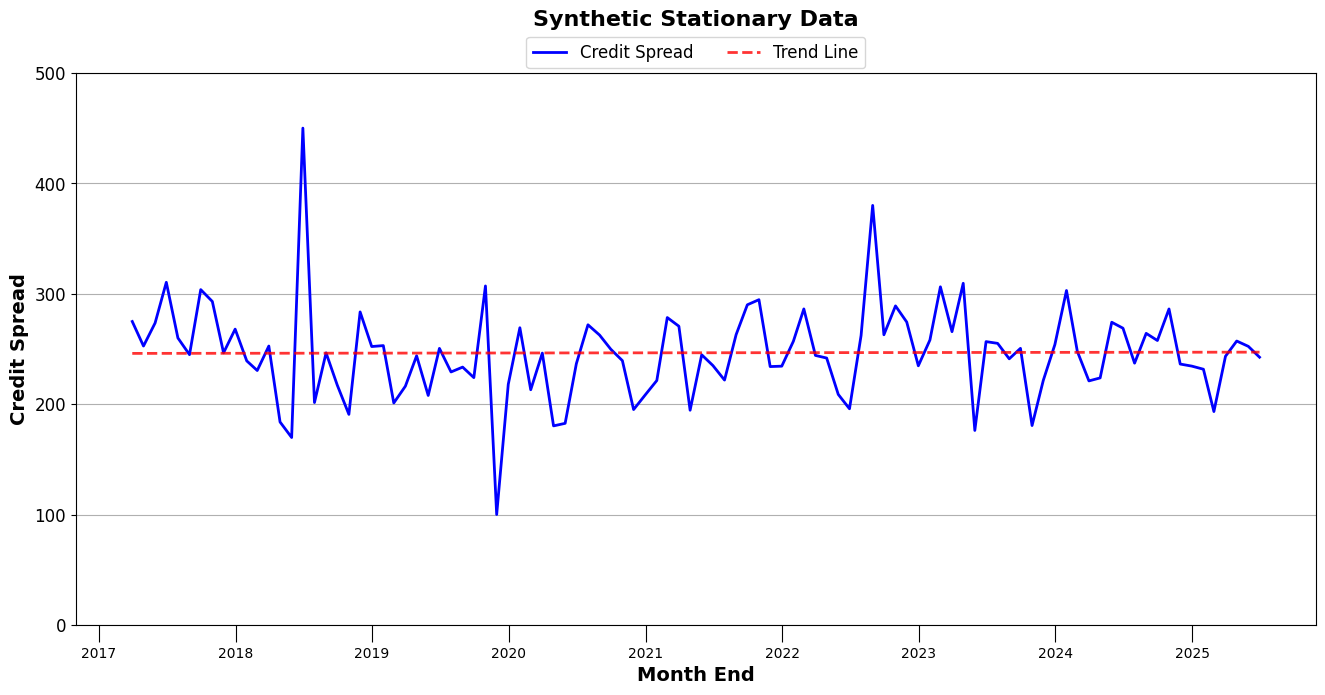

In [351]:
# Plot Ccomponents
title = "Synthetic Stationary Data"
yticks = [0, 100, 200, 300, 400, 500]
colors= ["Blue", "red", "#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', trend_line=True)

##### Forecasting Holt-Winters

In [352]:
## Split the data for all future models
train_data, test_data = split_data(stationary, 'data', 12)

Train period: 2017-03-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 88 months
Test size: 12 months


In [353]:
best_hype = hyperparameter_tuning(train_data)

HYPERPARAMETERS: Trend: None | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.13 | MAPE: 13.38%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.12 | MAPE: 12.84%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.18 | MAPE: 12.65%
HYPERPARAMETERS: Trend: add | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.00 | MAPE: 13.80%
HYPERPARAMETERS: Trend: None | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: -0.00 | MAPE: 13.82%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.15 | MAPE: 13.37%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.18 | MAPE: 12.65%

Best ARIMA model: ['add', 'add', True]
AIC: 0.18, MAPE: 12.65%


In [354]:
# Fit the Model
data = fit_model(stationary, train_data, test_data, best_hype[0], best_hype[1], best_hype[2])
    

In [355]:
# test the fitted values for the training dataset
test_fitted_values(stationary['data'][:-12], data['hw_train'][:-12])

MAPE: 12.65%
R²: 0.183
Directional Accuracy: 62.50%


In [356]:
# Test the forecasted values
test_fitted_values(stationary['data'][-12:], data['hw_forecast'][-12:])

MAPE: 8.59%
R²: -0.590
Directional Accuracy: 41.67%


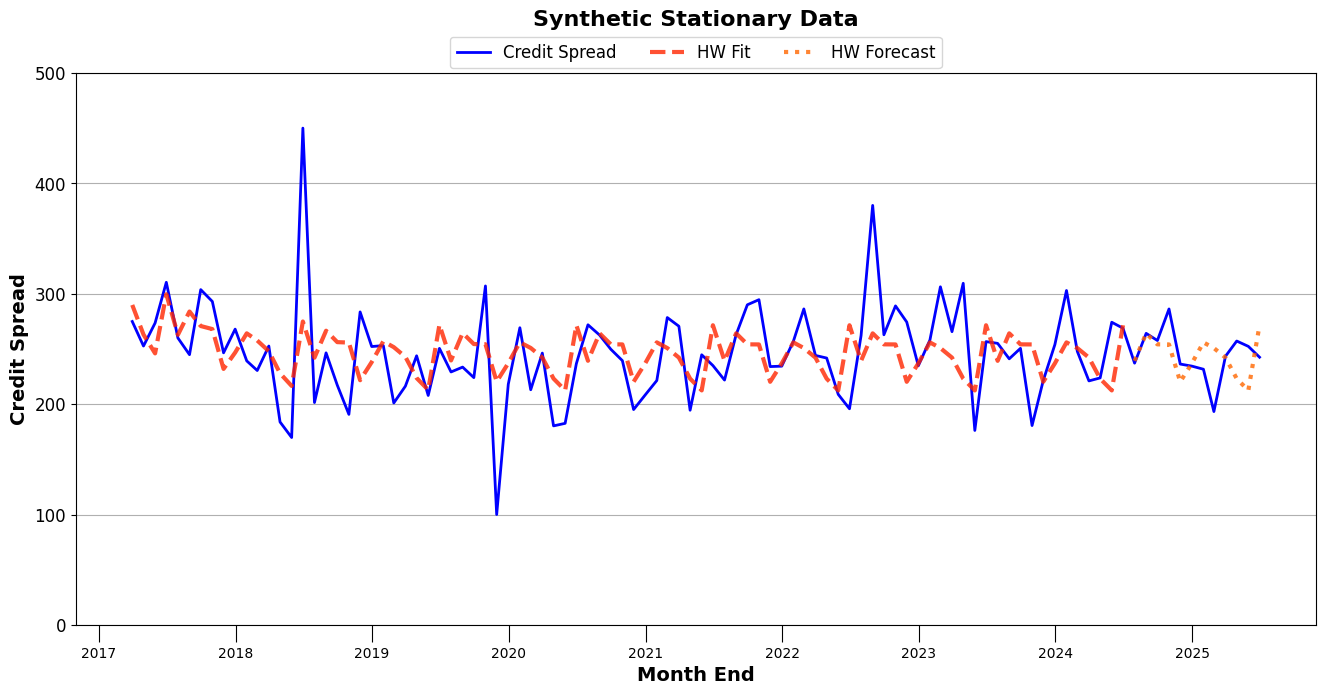

In [357]:
plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', hw=True)

##### ARIMA

In [358]:

best_model = arima_training(train_data, test_data)
arima_forecast = arima_forecast(stationary, train_data, test_data, best_model)

ARIMA(0, 0, 1): AIC=925.8, MAPE=nan%
ARIMA(1, 0, 0): AIC=925.8, MAPE=nan%
ARIMA(1, 0, 1): AIC=927.7, MAPE=nan%
ARIMA(2, 0, 1): AIC=928.8, MAPE=nan%
ARIMA(1, 0, 2): AIC=928.9, MAPE=nan%
ARIMA(2, 0, 2): AIC=930.5, MAPE=nan%

Best ARIMA model: (0, 0, 1)
AIC: 925.8, MAPE: nan%


In [359]:
# test the fitted values for the training dataset
test_fitted_values(stationary['data'][:-12], data['arima_train'][:-12])

MAPE: 13.89%
R²: 0.001
Directional Accuracy: 64.77%


In [360]:
# Test the forecasted values
test_fitted_values(stationary['data'][-12:], data['arima_forecast'][-12:])

MAPE: 6.81%
R²: -0.007
Directional Accuracy: 8.33%


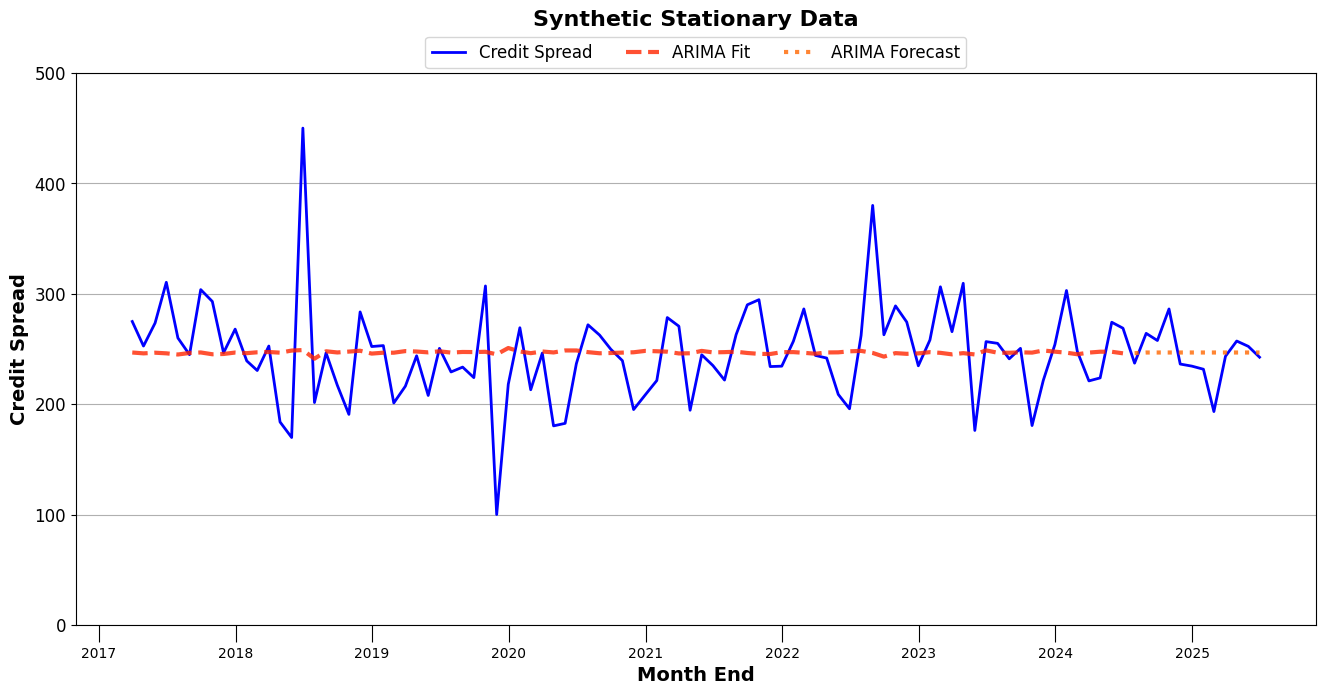

In [361]:
plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', arima=True)